# Fine Tunning

In [1]:
import torch
import torchvision
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.0.0+cu117
torchvision version: 0.15.1+cu117


In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from torchinfo import summary

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Importing Dataset (same as in 04)

In [4]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import os
from  pathlib import Path
from PIL import Image

In [5]:
# Create a transforms pipeline manually (required for torchvision < 0.13)
data_transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), 
    # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
    # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) 
    # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])
class CustomImageDataset(Dataset):
    def __init__(self, img_dir: str, transform = None, target_transform = None):
        # in case annotations are in a csv file, uncomment below.
        # self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = Path(img_dir)
        self.transform = transform
        self.target_transform = target_transform
        self.paths = list(self.img_dir.glob("*/*.jpg"))
        self._classes = sorted(
            entry.name for entry in os.scandir(self.img_dir) if entry.is_dir()
        )
        self._class_to_idx = {cls_name: i for i, cls_name in enumerate(self._classes)}
        self._idx_to_class = {i: cls_name for i, cls_name in enumerate(self._classes)}

    @property
    def classes(self):
        return self._classes
    @property
    def class_to_idx(self):
        return self._class_to_idx
    @property
    def idx_to_class(self):
        return self._idx_to_class
    
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx: int) -> tuple[Image.Image|torch.Tensor, int|torch.Tensor]:
        image = Image.open(str(self.paths[idx]))
        label = self._class_to_idx[self.paths[idx].parent.name]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [6]:
train_dir = "data/pizza_steak_sushi/train"
test_dir = "data/pizza_steak_sushi/test"
train_data_custom = CustomImageDataset(img_dir = train_dir, 
                                      transform = data_transform)
test_data_custom = CustomImageDataset(img_dir = test_dir, 
                                     transform = data_transform)
train_data_custom, test_data_custom

(<__main__.CustomImageDataset at 0x7f8274cea710>,
 <__main__.CustomImageDataset at 0x7f8274ce9d20>)

In [7]:
train_dataloader_custom = DataLoader(dataset=train_data_custom, batch_size=32, shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom, batch_size=32, shuffle=False) 
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7f8274cbbeb0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f8274cbbf10>)

In [8]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [9]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [10]:
auto_train_data_custom = CustomImageDataset(img_dir = train_dir, 
                                      transform = auto_transforms)
auto_test_data_custom = CustomImageDataset(img_dir = test_dir, 
                                     transform = auto_transforms)
auto_train_dataloader_custom = DataLoader(dataset=auto_train_data_custom, 
                                          batch_size=32, shuffle=True)
auto_test_dataloader_custom = DataLoader(dataset=auto_test_data_custom, 
                                    batch_size=32, shuffle=False) 

# Modelling

In [11]:
from sklearn.metrics import classification_report
from torchmetrics import F1Score
from tqdm.auto import tqdm
from torch import nn
from typing import Any
import numpy as np

/home/ivo/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Base Model

In [12]:
class BaseClass(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.train_loss_values = []
        self.test_loss_values = []
        self.f1_macro_train = []
        self.f1_macro_test = []
        self.f1_micro_train = []
        self.f1_micro_test = []
        self.f1_macro = F1Score(task="multiclass", num_classes = num_classes,
                          average="macro")
        self.f1_micro = F1Score(task="multiclass", num_classes = num_classes,
                          average="micro")

    def train_loop(self, dataloader: DataLoader, loss_fn:nn.modules.loss._Loss, 
                   optimizer: torch.optim.Optimizer) -> tuple[Any,Any,Any]:
        size = len(dataloader.dataset) # type: ignore
        num_batches = len(dataloader)
        self.train()
        train_loss,f1_macro, f1_micro = 0,0,0
        for batch, (input, labels) in enumerate(dataloader):
            input, labels = input.to(device), labels.to(device)
            # CrossEntropyLoss works directly with logits as inputs
            logits = self(input)
            # CrossEntropyLoss expects a tensor of type long as targets.
            # if we don't do the type casting outside the loss function, we get an error
            labels_long = labels.to(dtype=torch.long)
            loss = loss_fn(logits, labels_long)
            # we'll add the loss accross batches/steps, and in the end average them.
            # and for this, we need a new variable like train_loss to avoid  
            # RuntimeError:Trying to backward through the graph a second time
            train_loss += loss
            # return rows with prob like quantities of size 6
            pred = nn.Softmax(dim=1)(logits).argmax(dim=1) 
            f1_macro += self.f1_macro(pred, labels)
            f1_micro += self.f1_micro(pred, labels)  
            # also equal to self.f1(nn.Softmax(dim=1)(logits), labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # uncomment below for printing losses during batch training
            # if batch % 100 == 0:
            # loss, current = loss.item(), (batch + 1) * len(X)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        train_loss /= num_batches
        f1_macro /= num_batches # I'm not sure about the implications of avg over f1 score...
        f1_micro /= num_batches
        return train_loss, f1_macro, f1_micro
    
    def test_loop(self, dataloader:DataLoader, 
                  loss_fn:nn.modules.loss._Loss) -> tuple[Any,Any,Any]:
        num_batches = len(dataloader)
        self.eval()
        with torch.inference_mode():
            test_loss,f1_macro, f1_micro = 0,0,0
            for batch, (input, labels) in enumerate(dataloader):
                input, labels = input.to(device), labels.to(device)
                logits = self(input)
                labels_long = labels.to(dtype=torch.long)
                loss = loss_fn(logits, labels_long)
                test_loss += loss
                pred = nn.Softmax(dim=1)(logits).argmax(dim=1)
                f1_macro += self.f1_macro(pred, labels)
                f1_micro += self.f1_micro(pred, labels)
            test_loss /= num_batches
            f1_macro /= num_batches
            f1_micro /= num_batches 
        return test_loss, f1_macro, f1_micro
    
    def train_model(self, dataloader:DataLoader, loss_fn:nn.modules.loss._Loss, 
                    optimizer: torch.optim.Optimizer, n_epochs:int = 100, 
                    verbose: bool = False) -> None:
        for epoch in tqdm(range(1,n_epochs+1)):
            train_loss, train_f1_macro, train_f1_micro = self.train_loop(
                dataloader = dataloader, loss_fn = loss_fn, optimizer = optimizer
            )
            self.train_loss_values.append(train_loss.detach().cpu().numpy())
            self.f1_macro_train.append(train_f1_macro.detach().cpu().numpy())
            self.f1_micro_train.append(train_f1_micro.detach().cpu().numpy())
            test_loss, test_f1_macro, test_f1_micro = self.test_loop(
                dataloader = dataloader, loss_fn = loss_fn
            )
            self.test_loss_values.append(test_loss.detach().cpu().numpy())
            self.f1_macro_test.append(train_f1_macro.detach().cpu().numpy())
            self.f1_micro_test.append(train_f1_micro.detach().cpu().numpy())
            if verbose:
                print(f"\nEpoch {epoch}\n-------------------------------")
                print(
                    f"{loss_fn._get_name()} Train Loss: {train_loss} |"
                    f"{loss_fn._get_name()} Test Loss: {test_loss}"
                )
                print(
                    f"F1 Train Score (macro,micro): {train_f1_macro,train_f1_micro}  |"
                    f"F1 Test Score (macro,micro): {test_f1_macro,test_f1_micro}"
                )
    
    def predict(self, input: torch.Tensor) -> tuple[torch.Tensor,torch.Tensor]:
        self.eval()
        with torch.inference_mode():
            logits = self(input.to(device=device, dtype=torch.float32))
            pred_probs = nn.Softmax(dim=1)(logits)
            pred_class = pred_probs.argmax(dim=1)
        return pred_probs, pred_class
    
    def evaluation_report(self, dataloader: DataLoader, labels_names: list[str]):
        y_pred = []
        y_true = []
        for batch, (inputs_per_batch, labels_per_batch) in enumerate(dataloader):
                _, y_pred_class = self.predict(inputs_per_batch)
                y_pred.append(y_pred_class.cpu().numpy())
                y_true.append(labels_per_batch.cpu().numpy())
        y_true_1D = np.concatenate(y_true)
        y_pred_1D = np.concatenate(y_pred)
        print(classification_report(y_pred = y_pred_1D, y_true = y_true_1D,
                                target_names = labels_names))
        
    def plot_loss_curves(self): 
        epochs = range(len(self.test_loss_values))
        # Setup a plot 
        plt.figure(figsize=(15, 7))
        # Plot loss
        plt.subplot(1, 3, 1)
        plt.plot(epochs, self.train_loss_values, label='Train')
        plt.plot(epochs, self.test_loss_values, label='Test')
        plt.title('Loss')
        plt.xlabel('Epochs')
        plt.legend()

        # Plot f1 Macro
        plt.subplot(1, 3, 2)
        plt.plot(epochs, self.f1_macro_train, label='Train')
        plt.plot(epochs, self.f1_macro_test, label='Test')
        plt.title('F1 Macro')
        plt.xlabel('Epochs')
        plt.legend()

        # Plot f1 Micro
        plt.subplot(1, 3, 3)
        plt.plot(epochs, self.f1_micro_train, label='Train')
        plt.plot(epochs, self.f1_micro_test, label='Test')
        plt.title('F1 Micro')
        plt.xlabel('Epochs')
        plt.legend();

    def pred_and_plot_image(self, image_path: str, class_names: list[str],
                        image_size: tuple[int, int] = (224, 224), transform = None,
                        device: str = device):
        img = Image.open(image_path)
        if transform is not None:
            image_transform = transform
        else:
            image_transform = self.weights.transforms()

        transformed_image = image_transform(img).unsqueeze(dim=0).to(device)
        pred_probs, pred_class = self.predict(transformed_image) 
        plt.figure()
        plt.imshow(img)
        plt.title(f"Pred: {class_names[pred_class]} | Prob: {pred_probs.max():.3f}")
        plt.axis(False);

### EfficientNet Custom Model

In [13]:
class FineTunedEfficientNet(BaseClass):
    def __init__(self, output_shape: int, device: str = "cpu"):
        super().__init__(num_classes = output_shape)
        self.weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT 
        # .DEFAULT = best available weights 
        self.model = torchvision.models.efficientnet_b0(weights=self.weights).to(device)
        # Freezing the layer type called features.
        for param in self.model.features.parameters():
            param.requires_grad = False
        # Recreate the classifier layer and seed it to the target device
        # seeding will create a Dropout layer with the same initial weights.
        torch.manual_seed(42)
        torch.cuda.manual_seed(42)
        self.model.classifier = torch.nn.Sequential(
            torch.nn.Dropout(p=0.2, inplace=True), # same as before
            torch.nn.Linear(in_features=1280, # same as before
                            out_features=output_shape, # this changes
                            bias=True)
        ).to(device)
    def forward(self, x: torch.Tensor):
        return self.model(x)

In [14]:
efficient_finetuned = FineTunedEfficientNet(output_shape=3, device=device)

In [15]:
efficient_finetuned.weights.transforms()

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [16]:
summary(model=efficient_finetuned, 
        input_size=(32, 3, 224, 224), # it's "input_size", not "input_shape"!
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"],
        device = device # or "cuda"
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
FineTunedEfficientNet (FineTunedEfficientNet)                     [32, 3, 224, 224]    [32, 3]              --                   Partial
├─EfficientNet (model)                                            [32, 3, 224, 224]    [32, 3]              --                   Partial
│    └─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    │    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   (928)                False
│    │    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112, 112]   (1,448)              False
│    │    └─Sequential (2)                                        [32, 16, 112, 112]   [32, 24, 56, 56]     (16,714)             False
│    │    └─Sequential (3)                     

Defining the loss function and optimizer.

In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(efficient_finetuned.parameters(), lr=0.001)


In [18]:
efficient_finetuned.train_model(auto_train_dataloader_custom, loss_fn = loss_fn, 
                      optimizer = optimizer, n_epochs = 5)

100%|██████████| 5/5 [00:11<00:00,  2.32s/it]


In [19]:
efficient_finetuned.evaluation_report(dataloader=auto_test_dataloader_custom,
                            labels_names = test_data_custom.classes
                            )

              precision    recall  f1-score   support

       pizza       0.88      0.92      0.90        25
       steak       0.70      1.00      0.83        19
       sushi       1.00      0.71      0.83        31

    accuracy                           0.85        75
   macro avg       0.86      0.88      0.85        75
weighted avg       0.89      0.85      0.85        75



We have much better results with the fine-tunned model than with the tinyVGG model!

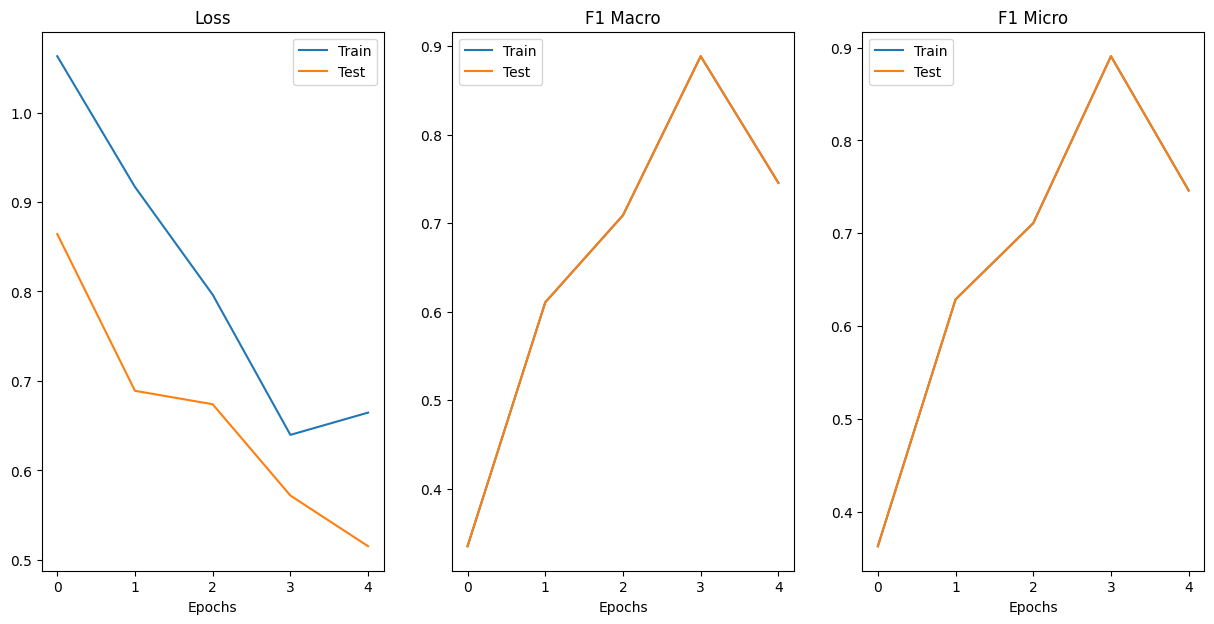

In [20]:
efficient_finetuned.plot_loss_curves()

In [21]:
efficient_finetuned.train_model(auto_train_dataloader_custom, loss_fn = loss_fn, 
                      optimizer = optimizer, n_epochs = 20)

100%|██████████| 20/20 [00:45<00:00,  2.29s/it]


In [22]:
efficient_finetuned.evaluation_report(dataloader=auto_test_dataloader_custom,
                            labels_names = test_data_custom.classes
                            )

              precision    recall  f1-score   support

       pizza       0.92      0.92      0.92        25
       steak       0.83      0.79      0.81        19
       sushi       0.84      0.87      0.86        31

    accuracy                           0.87        75
   macro avg       0.87      0.86      0.86        75
weighted avg       0.87      0.87      0.87        75



The model improved even more! (as expected, if you look at the loss functions) :)

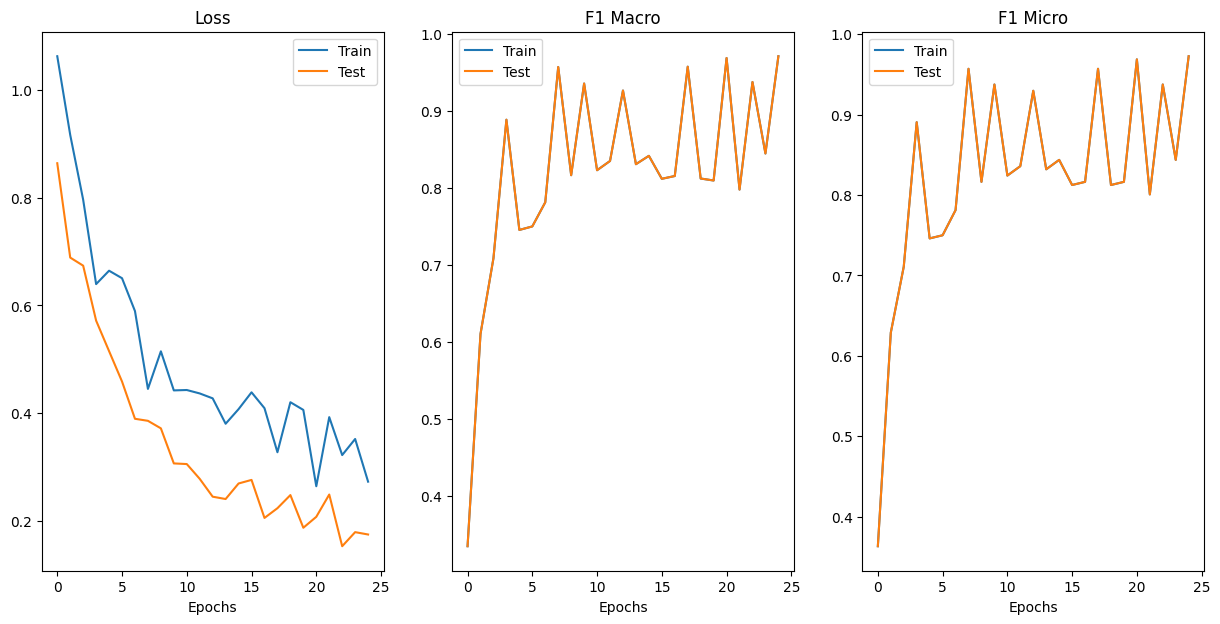

In [23]:
efficient_finetuned.plot_loss_curves()

### Predictions

In [31]:
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

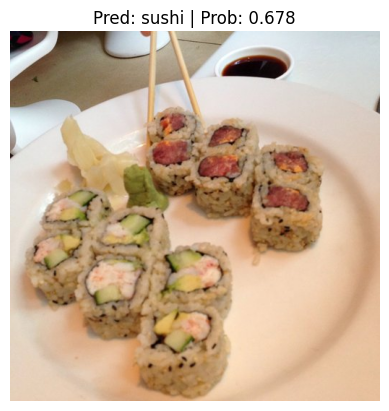

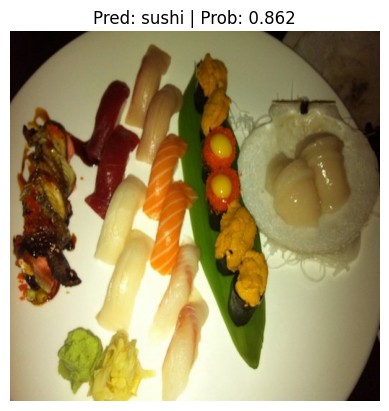

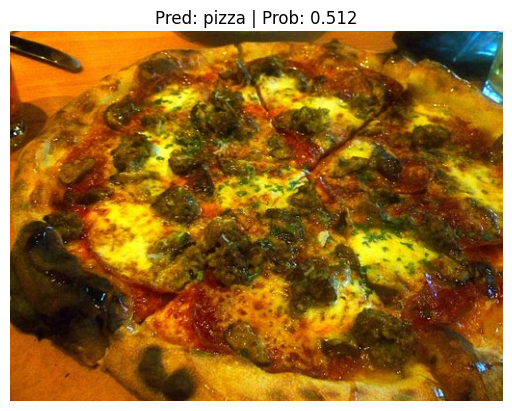

In [30]:
# Make predictions on and plot the images
for image_path in test_image_path_sample:
    efficient_finetuned.pred_and_plot_image(image_path=image_path, # type: ignore
                        class_names=auto_test_data_custom.classes,
                        image_size=(224, 224))